# **SeisMIC** Tutorial

![](../docs/source/figures/seismic_logo_small.png)

In the following, we will go through a simple example to compute a ambient noise correlations and monitor velocity changes using **SeisMIC**.

The source code is hosted here: [SeisMIC](https://github.com/PeterMakus/SeisMIC).

The documentation, which this notebook is based upon is located here:
[SeisMIC Documentation](https://petermakus.github.io/SeisMIC/).


As an exercise, we will download data from one channel of the station `X9.IR1` to investigate the coseismic velocity change caused by the M7.2 2016 Zhupanov earthquake
(see [Makus et. al., 2023](https://doi.org/10.1029/2022JB025738)).
Without further ado, we'll dive right into it starting with data download.

## 1. Download the raw data
**SeisMIC** uses [obspy](https://docs.obspy.org/) to download data from FDSN servers.

To download the data, we will use the [`seismic.trace_data.waveform.Store_Client`](https://petermakus.github.io/SeisMIC/modules/API.html#seismic.trace_data.waveform.Store_Client) class and its method `download_waveforms_mdl()`.

In [16]:
import os

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from seismic.trace_data.waveform import Store_Client

# Get notebook path for future reference of the database:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)

root = os.path.join(ipynb_path, 'data')
os.makedirs(root, exist_ok=True)

starttime = UTCDateTime(2016, 1, 25)
endtime = UTCDateTime(2016, 2, 5)
network = 'X9'
station = 'IR1'


c = Client('GEOFON')
sc = Store_Client(c, root, read_only=False)
sc.download_waveforms_mdl(
    starttime, endtime, clients=[c], network=network,
    station=station, location='*', channel='HH?')


/home/pm/miniforge3/envs/seismic/lib/python3.10/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "
[2023-07-17 13:05:28,237] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-07-17 13:05:28,237] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-07-17 13:05:28,239] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://geofon.gfz-potsdam.de.
[2023-07-17 13:05:28,239] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://geofon.gfz-potsdam.de.
[2023-07-17 13:05:28,240] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2023-07-17 13:05:28,240] - obspy.clients.fdsn.mass_downloader - INFO: Total

Some notes about this:
1. The method `download_waveforms_mdl()` expects a list of clients as input.
2. All arguments accept wildcards

If everything worked fine. This should have created a folder called `data/mseed` and `data/inventory`. Let's check

In [17]:
os.listdir('./data/')

['corr_0.03_0.1',
 'corr_1.85_5.55',
 'figures',
 'vel_change',
 'log',
 'corr_0.36_1.1',
 'corr_0.07_0.22',
 'wfc',
 'mseed',
 'corr_0.16_0.49',
 'inventory',
 'corr_0.82_2.47',
 'corr_4.16_12.49']

### 1.1 Plot a time-dependent spectrogram

A good first step to evaluate how the noise looks in the different frequency bands is by plotting a spectral series. SeisMIC possesses an efficient implentation using Welch windows.

<AxesSubplot:ylabel='$f$ [Hz]'>

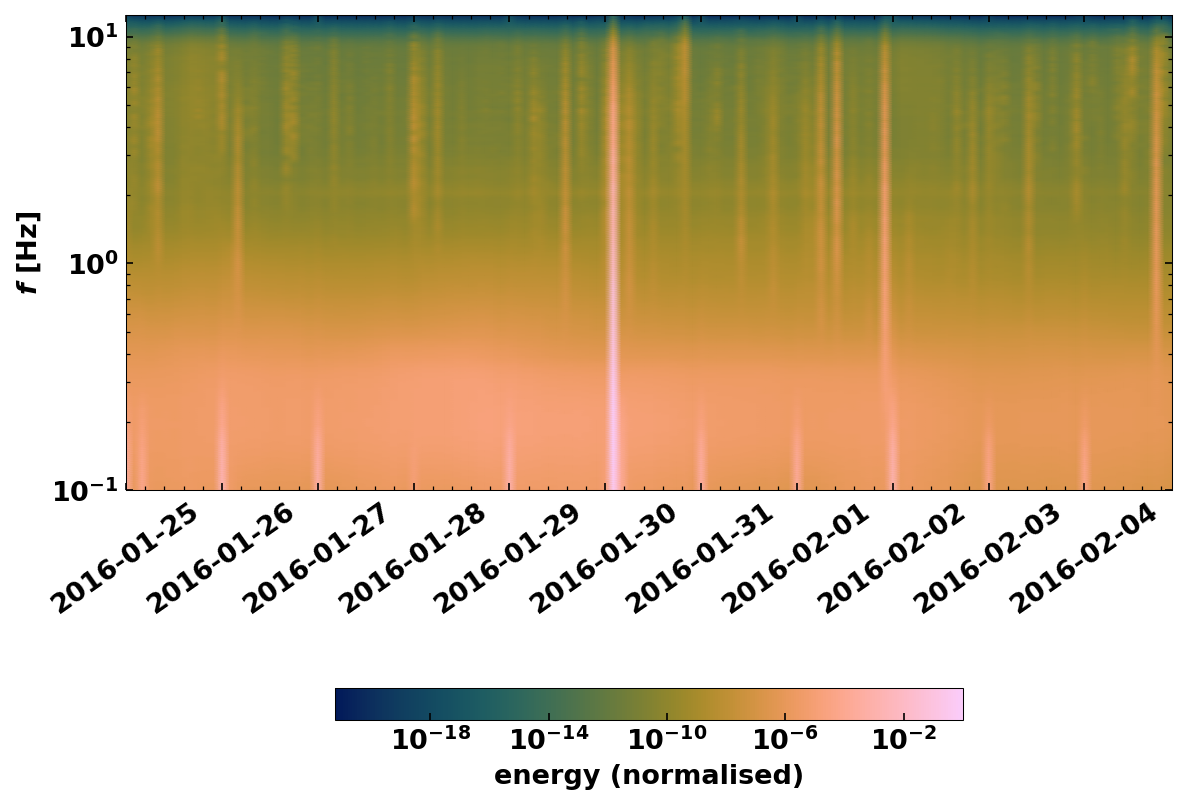

In [18]:
from seismic.plot.plot_spectrum import plot_spct_series
from matplotlib import pyplot as plt

f, t, S = sc.compute_spectrogram('X9', 'IR1', 'HHE', starttime, endtime, 7200, freq_max=12.5)
fig = plt.figure(figsize=(9, 7))
plot_spct_series(S, f, t, log_scale=True)

## 2. Compute Correlations
That seems to have worked, so we are ready to use this raw data to compute ambient noise correlations.

### 2.1 Parameters
Parameters are provided as a `yaml` file or a `dict` object. This tutorial comes with an yaml file to process the data. Let's have a short look at it using bash.

In [19]:
!cat params.yaml

#### Project wide parameters
# lowest level project directory
proj_dir : 'data'
# directory for logging information
log_subdir : 'log'
# levels:
# 'DEBUG', 'INFO', 'WARNING', 'ERROR', or 'CRITICAL'
log_level: 'WARNING'
# folder for figures
fig_subdir : 'figures'


#### parameters that are network specific
net:
    # list of stations used in the project
    # type: list of strings or string, wildcards allowed
    network : 'X9'
    station : 'IR1'

#### parameters for correlation (emperical Green's function creation)
co:
    # subdirectory of 'proj_dir' to store correlation
    # type: string
    subdir : 'corr'
    # times sequences to read for cliping or muting on stream basis
    # These should be long enough for the reference (e.g. the standard
    # deviation) to be rather independent of the parts to remove
    # type: string
    read_start : '2016-01-25 00:00:01.0'
    read_end : '2016-02-05 00:00:00.0'
    # type: float [seconds]
    # The longer the faster, but higher RAM usage.

Each of the parameters is described in the [Documentation](https://petermakus.github.io/SeisMIC/modules/correlate/get_started.html).

To start the computation of the correlation we will use [`MPI`](https://mpi4py.readthedocs.io/) and a simple python script, which could look like this:

In [20]:
!cat correlate.py

import os
# This tells numpy to only use one thread
# As we use MPI this is necessary to avoid overascribing threads
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from time import time

from obspy.clients.fdsn import Client

from seismic.correlate.correlate import Correlator
from seismic.trace_data.waveform import Store_Client

# Path to the paramter file we created in the step before
params = 'params.yaml'
# You don't have to set this (could be None)
client = Client('GEOFON')
# root is the same as proj_dir in params.yaml
root = 'data'
sc = Store_Client(client, root)

c = Correlator(sc, options=params)
print('Correlator initiated')
x = time()
st = c.pxcorr()
print('Correlation finished after', time()-x, 'seconds')


## 2.2 Start correlation
To start the correlation, we will use the `mpirun` command in bash:

Jupyter notebook limits the output, so if you wish to see the complete output, you might prefer actually executing these commands in a terminal.

In [21]:
import os
# This gives number of threads, usually twice as many as physical cores
ncpus = os.cpu_count()//2
!mpirun -n $ncpus python correlate.py

/home/pm/miniforge3/envs/seismic/lib/python3.10/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "
/home/pm/miniforge3/envs/seismic/lib/python3.10/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "
/home/pm/miniforge3/envs/seismic/lib/python3.10/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "
/home/pm/miniforge3/envs/seismic/lib/python3.10/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with cautio

Now let's have a look at those correlations. To do so, we use the [`CorrelationDataBase`](https://petermakus.github.io/SeisMIC/modules/API.html#seismic.db.corr_hdf5.CorrelationDataBase) object.
All correlations are saved in the folder `data/corr` as defined in our params.yaml file.

In [22]:
from seismic.db.corr_hdf5 import CorrelationDataBase

with CorrelationDataBase(f'data/corr/{network}-{network}.{station}-{station}.h5', mode='r') as cdb:
    # find the available labels
    print(list(cdb.keys()))

['co', 'stack_86398', 'subdivision']


**SeisMIC's** standard labels are `'subdivision` for the correlations of corr_len and `stack_*stacklen*` for the stack (with *stacklen* being the length of the stack in seconds).

**SeisMIC** uses some sort of "combined seed codes" structured as above.

In [23]:
with CorrelationDataBase(f'data/corr/{network}-{network}.{station}-{station}.h5', mode='r') as cdb:
    # find the available labels
    print(cdb.get_available_channels(
        tag='stack_86398', network=f'{network}-{network}', station=f'{station}-{station}'))
    print(cdb.get_available_starttimes(
        tag='subdivision', network=f'{network}-{network}', station=f'{station}-{station}', channel='*'))
    cst = cdb.get_data(f'{network}-{network}', f'{station}-{station}', 'HHE-HHE', 'subdivision')
print(type(cst))

# filter frequencies, so we can see something
cst = cst.filter('bandpass', freqmin=2, freqmax=4)

['HHE-HHE', 'HHN-HHN', 'HHZ-HHZ']
{'HHE-HHE': ['2016025T000001.0000Z', '2016025T010001.0000Z', '2016025T020001.0000Z', '2016025T030001.0000Z', '2016025T040001.0000Z', '2016025T050001.0000Z', '2016025T060001.0000Z', '2016025T070001.0000Z', '2016025T080001.0000Z', '2016025T090001.0000Z', '2016025T100001.0000Z', '2016025T110001.0000Z', '2016025T120001.0000Z', '2016025T130001.0000Z', '2016025T140001.0000Z', '2016025T150001.0000Z', '2016025T160001.0000Z', '2016025T170001.0000Z', '2016025T180001.0000Z', '2016025T190001.0000Z', '2016025T200001.0000Z', '2016025T210001.0000Z', '2016025T220001.0000Z', '2016025T230001.0000Z', '2016026T000001.0000Z', '2016026T010001.0000Z', '2016026T020001.0000Z', '2016026T030001.0000Z', '2016026T040001.0000Z', '2016026T050001.0000Z', '2016026T060001.0000Z', '2016026T070001.0000Z', '2016026T080001.0000Z', '2016026T090001.0000Z', '2016026T100001.0000Z', '2016026T110001.0000Z', '2016026T120001.0000Z', '2016026T130001.0000Z', '2016026T140001.0000Z', '2016026T150001.0

<class 'seismic.correlate.stream.CorrStream'>


`cst` is now a [`CorrStream`](https://petermakus.github.io/SeisMIC/modules/API.html#seismic.correlate.stream.CorrStream) - an obspy based object to handle correlations. We can plot those in a section plot for example by time:

<AxesSubplot:xlabel='$\\tau$ [s]'>

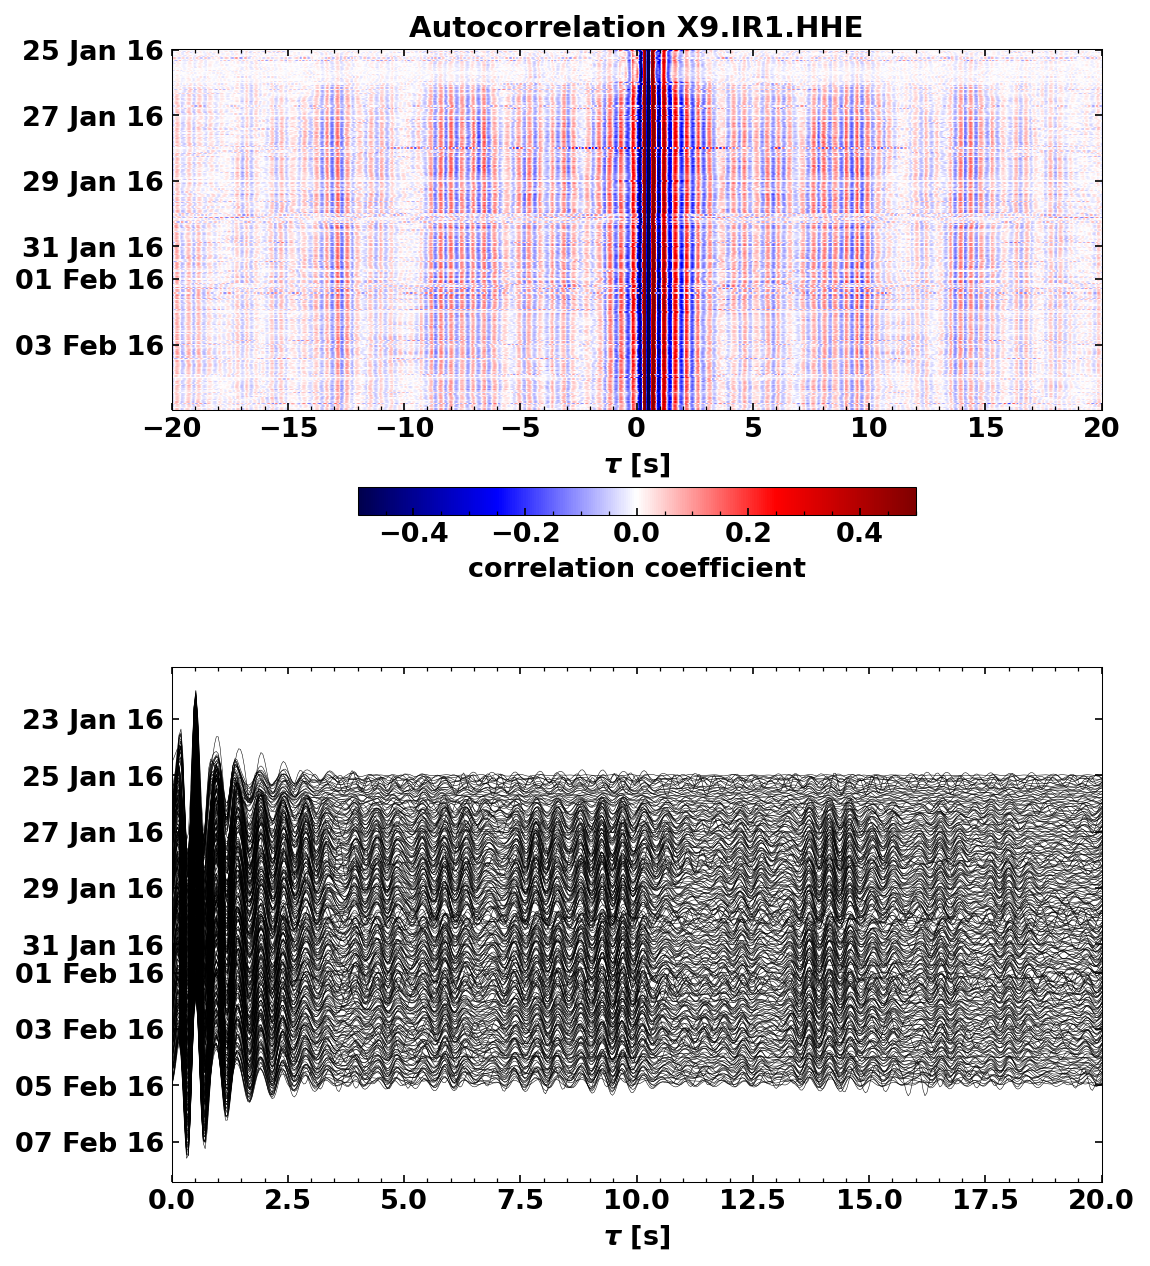

In [24]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 10))
ax0 = plt.subplot(2, 1, 1)

cst.plot(timelimits=[-20, 20], cmap='seismic', vmin=-0.5, vmax=0.5, ax=ax0)
ax0.set_title(f'Autocorrelation {network}.{station}.HHE')
ax1 = plt.subplot(2, 1, 2)
cst.plot(scalingfactor=3, timelimits=[0, 20], type='section', ax=ax1)

If you look very very closely, you can see a slight time shift in the late coda on January 30th. This time shift is associated to the Zhupanov earthquake. We will try to quantify the velocity change in the following.

We can also look at a single correlations or at a stack of correlations. SeisMIC can stack correlation with `CorrStream.stack`:

<AxesSubplot:xlabel='Lag Time [s]', ylabel='Correlation'>

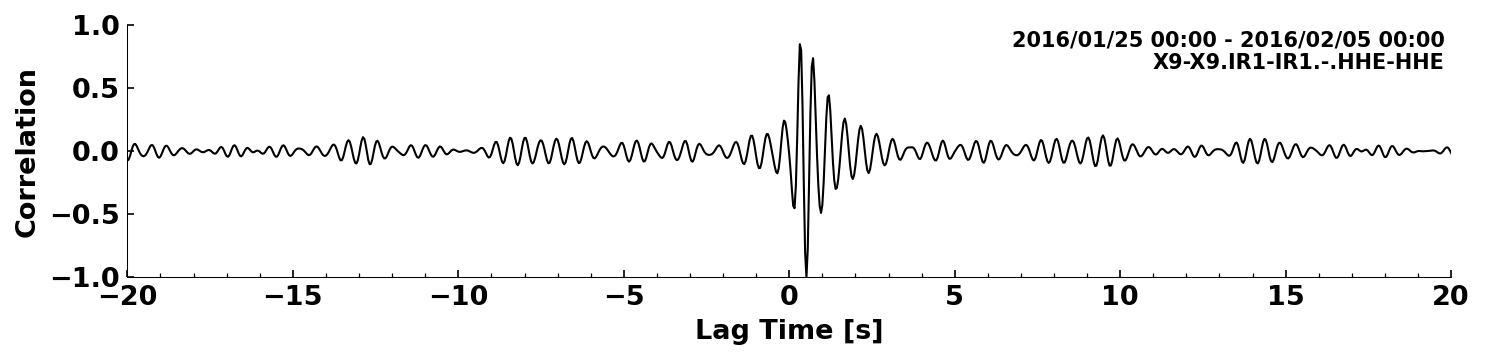

In [25]:
corrstack = cst.stack()[0]
corrstack.plot(tlim=[-20,20])

### Let's try and combine the two last plots

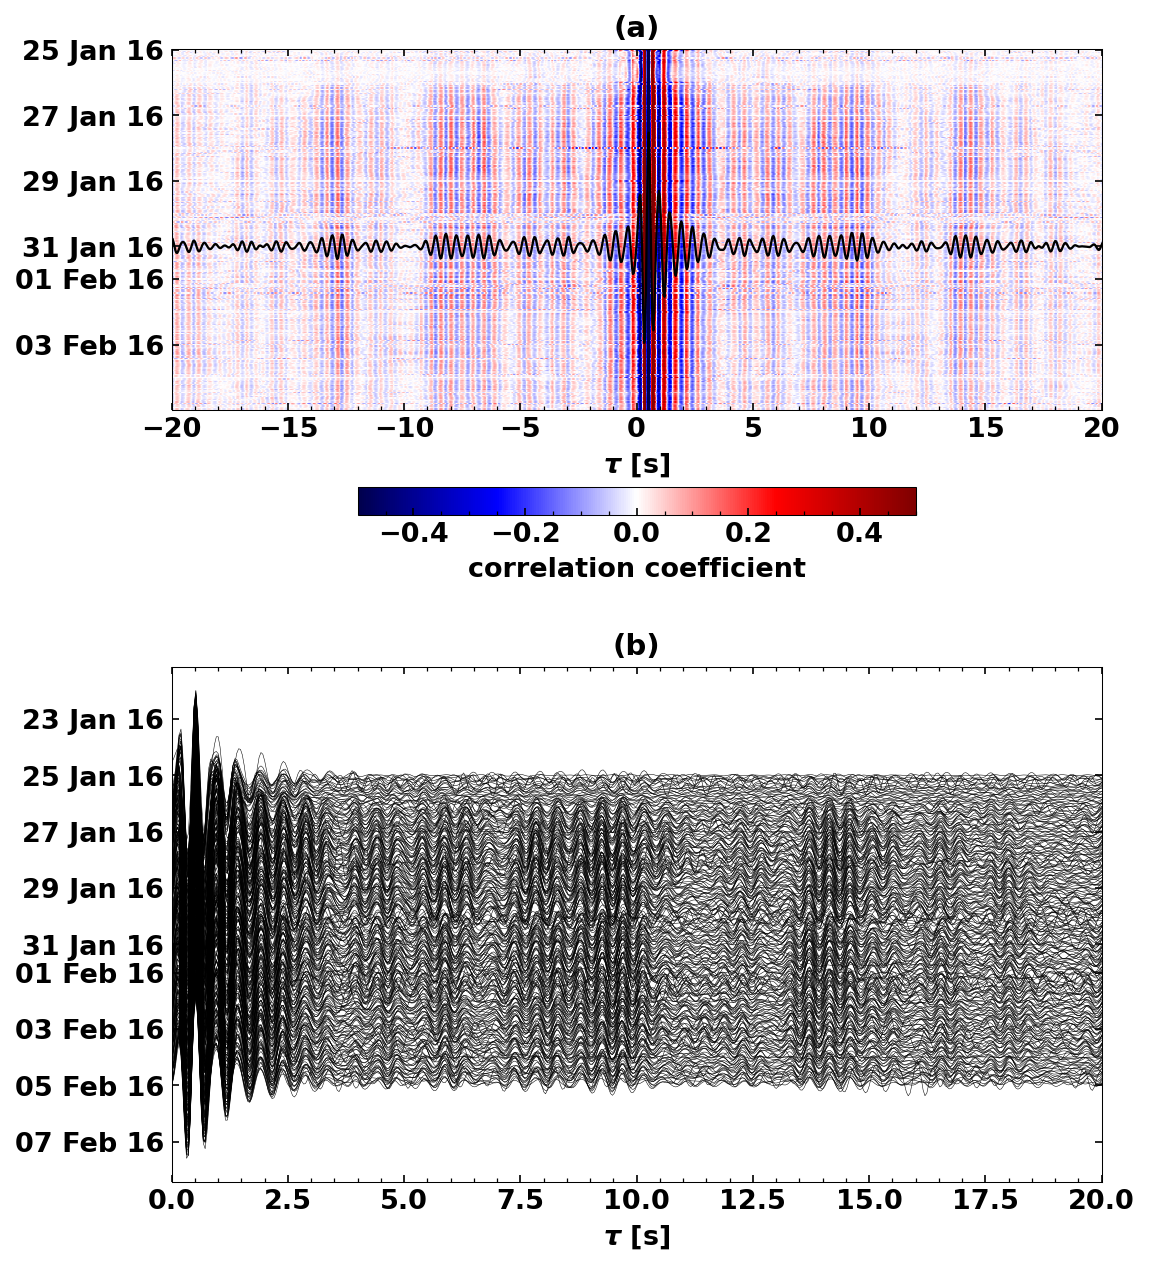

In [35]:
plt.figure(figsize=(8, 10))
ax0 = plt.subplot(2, 1, 1)

cst.plot(timelimits=[-20, 20], cmap='seismic', vmin=-0.5, vmax=0.5, ax=ax0)
ax0.set_title(f'(a)')
ax0.plot(
    corrstack.times(),
    [UTCDateTime(i).datetime for i in corrstack.data*3e5 +  UTCDateTime(2016, 1, 31).timestamp],
    color='k', zorder=100, linewidth=1.1)

ax1 = plt.subplot(2, 1, 2)
cst.plot(scalingfactor=3, timelimits=[0, 20], type='section', ax=ax1)
ax1.set_title(f'(b)')

## 3. Waveform Coherence

We can assess the average stability of the wavefield in different frequency
bands and along the lapse time axis using a measure called the waveform coherence
(see ,e.g., Steinmann, et al., 2021).
The waveform coherence is the zero lag correlation of two noise correlations.
Here we average them for one station and given frequency and lapse time bands.

For this step, we will have to compute a few more noise correlations over various
frequency bands. That's why the next cell will take a while.

In [57]:
!python wfc.py

/home/pm/miniforge3/envs/seismic/lib/python3.10/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "
100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.53it/s]
corr_0.03_0.1
100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]
corr_0.07_0.22
100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]
corr_0.16_0.49
100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]
corr_0.36_1.1
100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]
corr_0.82_2.47
100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]
corr_1.85_5.55
100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]
corr_4.16_12.49
100%|█████████████████████████████████████████████| 3/3 [00:02

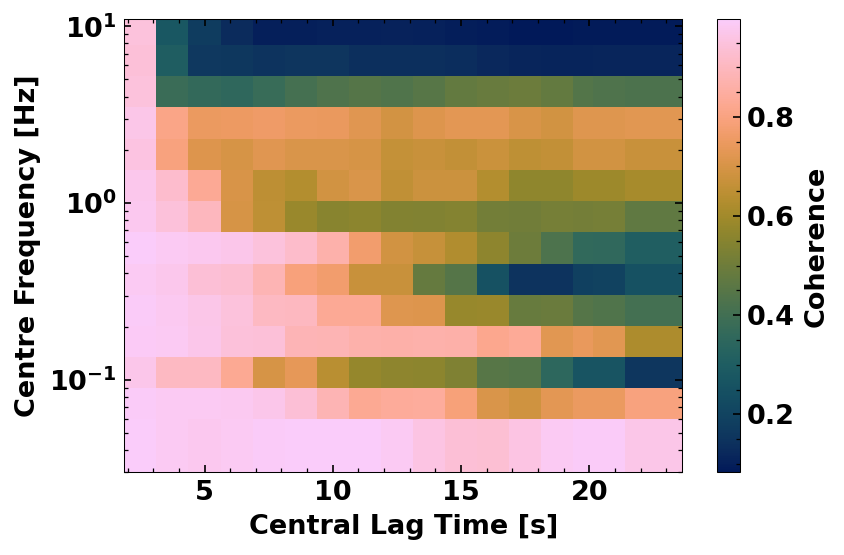

In [59]:
from seismic.monitor.wfc import WFCBulk
from seismic.monitor.wfc import read_wfc

wfcs = read_wfc('data/wfc/WFC-X9-X9.IR1-IR1.av.*.npz')
WFCBulk(wfcs).plot(log=True, cmap='batlow')

## 4. Monitoring

Next, we will compute a velocity change estimate using the stretching technique ([Sens-Schönfelder & Wegler, 2006](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2006gl027797)).
You can find the corresponding parameters in the `dv` section of the `params.yaml` file.

Similarly to the Correlation we can start the monitoring via a simple script:

In [12]:
!cat monitor.py

import os
# This tells numpy to only use one thread
# As we use MPI this is necessary to avoid overascribing threads
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from seismic.monitor.monitor import Monitor

yaml_f = 'params.yaml'
m = Monitor(yaml_f)
m.compute_velocity_change_bulk()


In [13]:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)

# multi-core is not necessarily useful for this example
# because the jobs are split into N jobs, where N is the number of
# component combinations (in our case N==1)
ncpus = os.cpu_count()//2
!mpirun -n $ncpus python ./monitor.py

0it [00:00, ?it/s]/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
saving to X9-X9_IR1-IR1_HHN-HHN
saving to X9-X9_IR1-IR1_HHE-HHE
saving to X9-X9_IR1-IR1_HHZ-HHZ
100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


### Make a first plot to get an idea of *dv/v*
We can use SeisMIC's inbuilt plotting function for that. The velocity changes will in general be shown in decimal values.

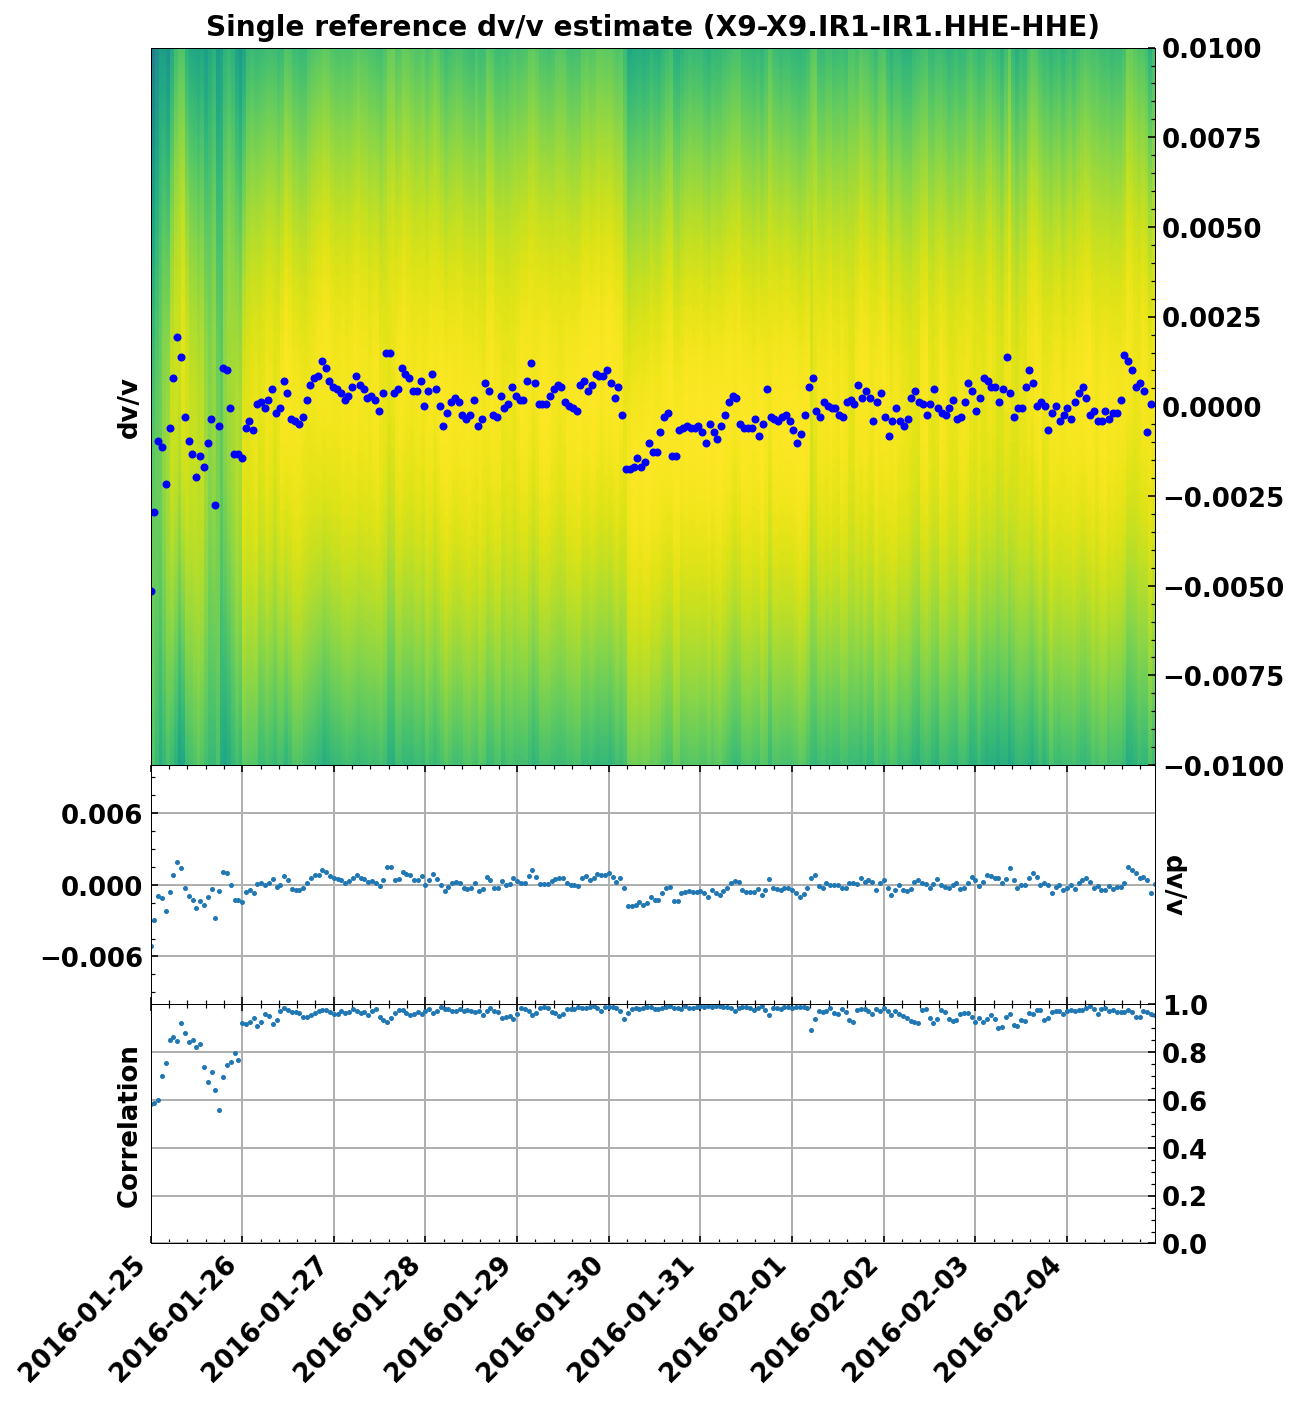

single_ref stretch velocity change estimate of X9-X9.IR1-IR1.HHE-HHE.
starttdate: Mon Jan 25 00:00:00 2016
enddate: Fri Feb  5 00:00:00 2016

processed with the following parameters: {'freq_min': 2.0, 'freq_max': 4.0, 'tw_start': 3.5, 'tw_len': 8.5}


In [27]:
from seismic.monitor.dv import read_dv
dv = read_dv(f'data/vel_change/DV-{network}-{network}.{station}-{station}.HHE-HHE.npz')
dv.plot(ylim=(-0.01,0.01))

# We can print some information about the dv object
print(dv)

Even with comparably little data, we can see the velocity drop on January 30th. Note that due to the high energy noise, we are able to retrieve a very high resolution estimate of *dv/v*.

## Make the plot look a little nicer
The plot above is very good if you just want to understand what is going on, but maybe it is not necessarily something you would want to put into a publication. Here is a code that makes the plot look like in the above mentioned publication

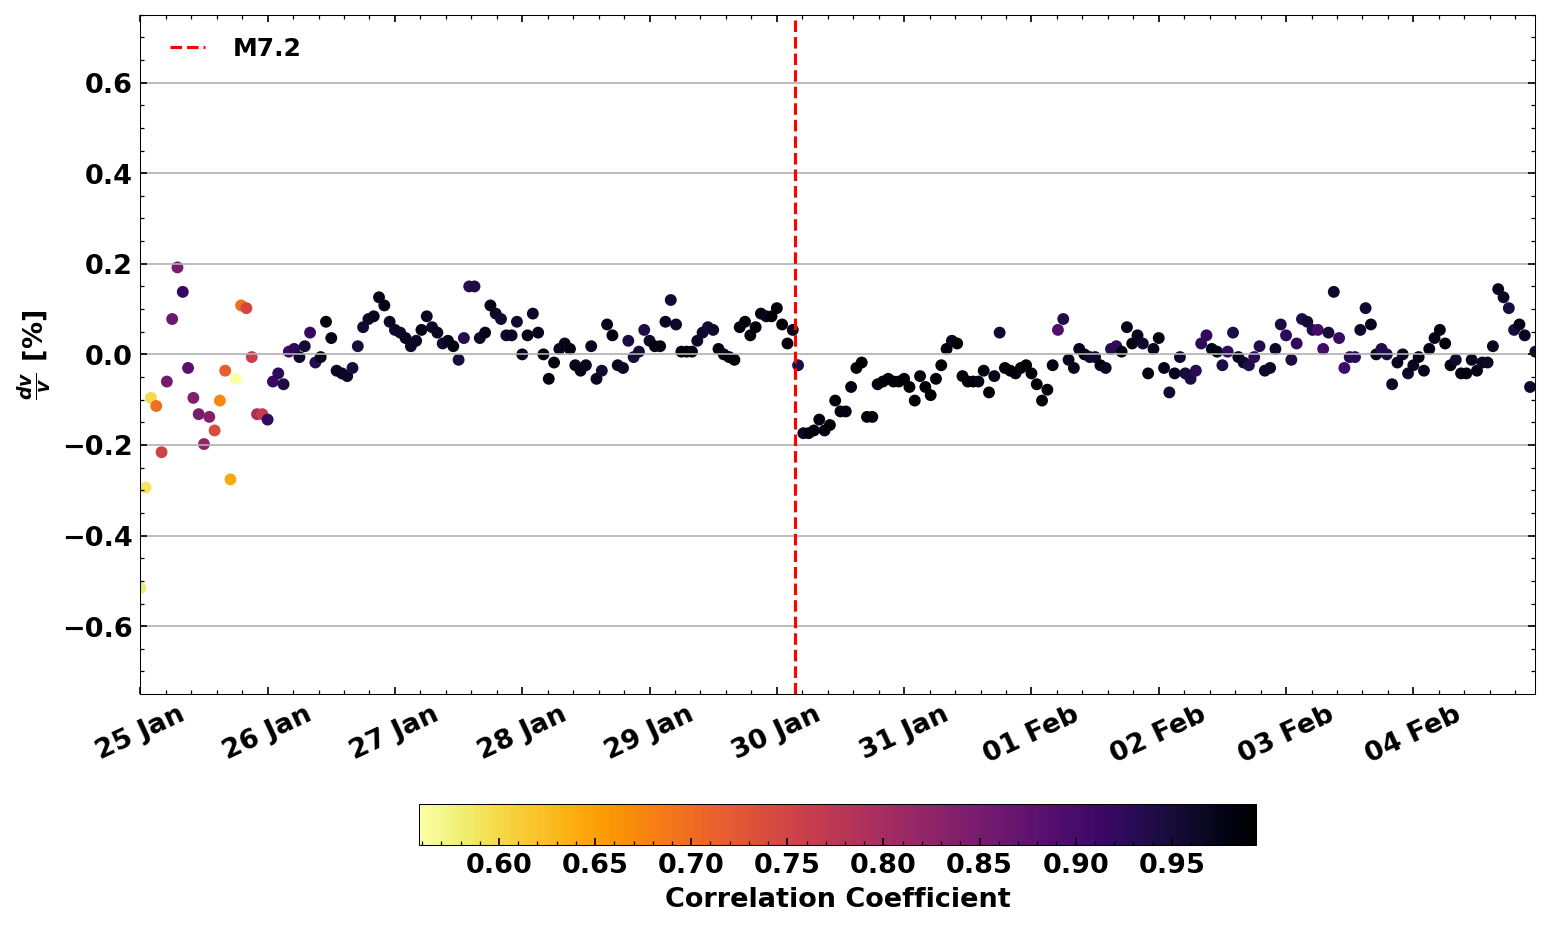

In [34]:
from obspy import UTCDateTime

from seismic.plot.plot_utils import set_mpl_params

set_mpl_params()

# Origin Time of the Zhupanov earthquake
otime = UTCDateTime(2016, 1, 30, 3, 25).datetime

fig, ax = dv.plot(style='publication', return_ax=True, ylim=(-.75,.75),
                  dateformat='%d %b')

plt.axvline(otime, linestyle='dashed', c='r', label='M7.2')
plt.legend()

# What comes next?

## Increasing the stability

In this case, we are fortunate enough to receive a high-resolution `dv/v` estimate with the given parameters (not quite by coincidence ;-)).

For many other datasets, you might not be able to achieve satisfactory stability.
Here are some suggestions on how you could tackle that:
1. Increase the smoothing. This can be done over a number of different ways, all of them can be configured in `params.yaml`:
    - increase `dv['win_len']` to stack correlations over the defined amount of time (in seconds)
    - in `dv['preprocessing']` increase the parameter `wsize` of the `smooth` function to smoooth the correlation functions over a larger amount of time (see [documentation](https://petermakus.github.io/SeisMIC/modules/API.html#seismic.correlate.stream.CorrBulk.smooth))
    - In `dv['postprocessing']` set a smoothing of the similarity matrix (see [documentation](https://petermakus.github.io/SeisMIC/modules/API.html#seismic.monitor.dv.DV.smooth_sim_mat))
2. Try different frequencies, different lag time windows of the coda or a different preprocessing.
3. Stack the results from several component combinations as done in [Illien et al. 2023](https://academic.oup.com/gji/article-abstract/234/1/124/7008901). The corresponding function in Seismic is in [seismic.monitor.monitor.average_component_combinations()](https://petermakus.github.io/SeisMIC/modules/API.html#seismic.monitor.monitor.average_components)

## Explore other processing possibilities
There are a large number of flavours for different processing options explored. Some of which are natively shipped in SeisMIC. You can experiment with options to processing your noise correlation functions differently or compute *dv/v* differently (e.g., thinking about other algorithms than the stretching technique). By the way: the dictionaries in the different processing parameters in `params.yaml` allow to import external functions as long as they are scripted in the right way (see link).

## Invert for a velocity change map
The module `seismic.monitor.spatial` implements the surface wave spatial inversion as proposed by [Obermann et al. (2013)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013JB010399). Consult the documentation, to learn how to work with spatial inversions.

# Bonus: Create a velocity change map

This takes quite a while longer than the other examples as more data needs to be downloaded to make this a somewhat meaningfull example. In this example, we will try and quantify the networks reaction to the Zhupanov earthquake (as above).

## Data download

In [31]:
import os

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from seismic.trace_data.waveform import Store_Client

# Get notebook path for future reference of the database:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)

root = os.path.join(ipynb_path, 'data')
os.makedirs(root, exist_ok=True)

starttime = UTCDateTime(2016, 1, 28)
endtime = UTCDateTime(2016, 2, 2)
network = 'X9'
station = 'SV*'


c = Client('GEOFON')
sc = Store_Client(c, root, read_only=False)
sc.download_waveforms_mdl(
    starttime, endtime, clients=[c], network=network,
    station=station, location='*', channel='HH?')


[2023-07-12 17:01:30,494] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-07-12 17:01:30,494] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-07-12 17:01:30,494] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-07-12 17:01:30,497] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://geofon.gfz-potsdam.de.
[2023-07-12 17:01:30,497] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://geofon.gfz-potsdam.de.
[2023-07-12 17:01:30,497] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://geofon.gfz-potsdam.de.
[2023-07-12 17:01:30,499] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2023-07-12 17:01:30,499] - obspy.clients.fdsn.mass_downloader - INFO: 

## Correlate

In [3]:
import os
# This gives number of threads, usually twice as many as physical cores
ncpus = os.cpu_count()//2
ncpus = 1
!mpirun -n $ncpus python correlate_network.py
#['X9', 'SV13'], ['X9', 'SV3'], ['X9', 'SV7']]
#['X9', 'SV3', 'HHE'], ['X9', 'SV3', 'HHN'], ['X9', 'SV3', 'HHZ'], ['X9', 'SV7', 'HHE'], ['X9', 'SV7', 'HHN'], ['X9', 'SV7', 'HHZ'], ['X9', 'SV13', 'HHE'], ['X9', 'SV13', 'HHN'], ['X9', 'SV13', 'HHZ']

What is in self.station [['X9', 'IR1'], ['X9', 'IR12'], ['X9', 'IR17'], ['X9', 'IR18'], ['X9', 'IR3'], ['X9', 'SV13'], ['X9', 'SV3'], ['X9', 'SV7']]
avail_raw_data [['X9', 'IR1', 'HHE'], ['X9', 'IR1', 'HHN'], ['X9', 'IR1', 'HHZ'], ['X9', 'IR12', 'HHE'], ['X9', 'IR12', 'HHN'], ['X9', 'IR12', 'HHZ'], ['X9', 'IR17', 'HHE'], ['X9', 'IR17', 'HHN'], ['X9', 'IR17', 'HHZ'], ['X9', 'IR18', 'HHE'], ['X9', 'IR18', 'HHN'], ['X9', 'IR18', 'HHZ'], ['X9', 'IR3', 'HHE'], ['X9', 'IR3', 'HHN'], ['X9', 'IR3', 'HHZ'], ['X9', 'SV7', 'HHE'], ['X9', 'SV7', 'HHN'], ['X9', 'SV7', 'HHZ'], ['X9', 'SV3', 'HHE'], ['X9', 'SV3', 'HHN'], ['X9', 'SV3', 'HHZ'], ['X9', 'SV13', 'HHE'], ['X9', 'SV13', 'HHN'], ['X9', 'SV13', 'HHZ']]
Correlator initiated
  0%|          | 0/5 [00:00<?, ?it/s]^C
[mpiexec@pm-Latitude-5310-2-in-1] Sending Ctrl-C to processes as requested
[mpiexec@pm-Latitude-5310-2-in-1] Press Ctrl-C again to force abort
  0%|          | 0/5 [00:02<?, ?it/s]
Traceback (most recent call last):
  File "/home/pm/D

## Compute dv/v

In [8]:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)

# multi-core is not necessarily useful for this example
# because the jobs are split into N jobs, where N is the number of
# component combinations (in our case N==1)
ncpus = 1
!mpirun -n $ncpus python ./monitor_network.py

['X9-X9', 'X9-X9', 'X9-X9', 'X9-X9', 'X9-X9', 'X9-X9', 'X9-X9', 'X9-X9'] ['IR17-IR17', 'IR3-IR3', 'SV13-SV13', 'IR1-IR1', 'IR12-IR12', 'SV3-SV3', 'IR18-IR18', 'SV7-SV7'] ['data/corr/X9-X9.IR17-IR17.h5', 'data/corr/X9-X9.IR3-IR3.h5', 'data/corr/X9-X9.SV13-SV13.h5', 'data/corr/X9-X9.IR1-IR1.h5', 'data/corr/X9-X9.IR12-IR12.h5', 'data/corr/X9-X9.SV3-SV3.h5', 'data/corr/X9-X9.IR18-IR18.h5', 'data/corr/X9-X9.SV7-SV7.h5']
 33%|███▎      | 8/24 [00:09<00:18,  1.15s/it]^C
[mpiexec@pm-Latitude-5310-2-in-1] Sending Ctrl-C to processes as requested
[mpiexec@pm-Latitude-5310-2-in-1] Press Ctrl-C again to force abort
 33%|███▎      | 8/24 [00:09<00:18,  1.16s/it]
Traceback (most recent call last):
  File "/home/pm/Documents/SeisMIC/examples/./monitor_network.py", line 23, in <module>
    m.compute_velocity_change_bulk()
  File "/home/pm/Documents/SeisMIC/src/seismic/monitor/monitor.py", line 352, in compute_velocity_change_bulk
    self.compute_velocity_change(
  File "/home/pm/Documents/SeisMIC/src

In [45]:
from obspy import UTCDateTime

from seismic.monitor.spatial import DVGrid
from seismic.monitor.dv import read_dv

# define map dimensions
# New, slightly larger coverage
lat = 55.6
lon = 160

# Y-extent in km
y = 80

# X-Extent in km
x = 30

# Resolution
res = .5  # km

# time to check dv/v at
times = [
    UTCDateTime('2016-01-30T00:00:00'),
    UTCDateTime('2016-01-30T12:00:00')]

# inversion parameters
# geo-parameters
vel = 1  # km/s
# mean free path in kilometres
mf_path = 80
# precision of the numerical integration
dt = .05  # s

# Damping parameters for Least-Squares Inversion
# needs to be thoroughly tested, e.g., L-curve criterion
corr_len = 1  # km
std_model = .15

dvs_all = read_dv('./data/vel_change/DV-*.npz')

# create empty grid

dvgs = []
for time in times:
    dvg = DVGrid(lat, lon, res, x, y)

    dvg.compute_dv_grid(
        dvs_all, time, dt, vel, mf_path, res, corr_len, std_model)
    dvgs.append(dvg)

<Axes: xlabel='Easting [km]', ylabel='Northing [km]'>

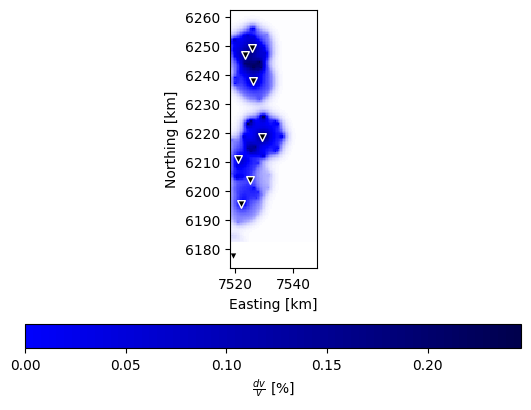

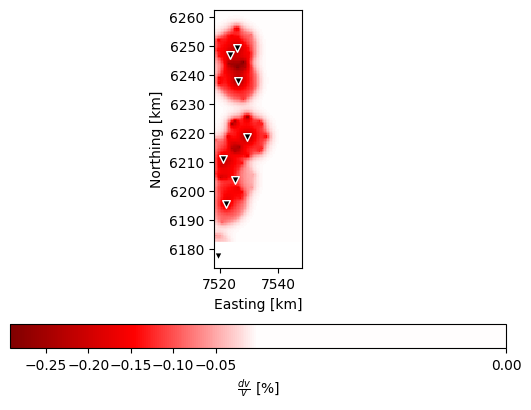

In [46]:
dvgs[0].plot()
dvgs[1].plot()

## Spatial Inversion of dv/v
A demonstration with real data would require a bit too much download and a very dense network.

So for this demonstration we commit a little inversion crime and try to re-obtain a velocity change model that is already known to us.

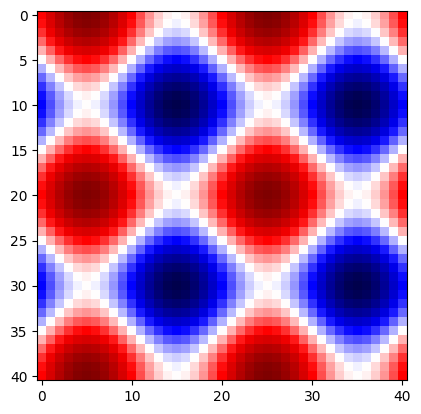

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from seismic.monitor.spatial import DVGrid


# define map dimensions
# New, slightly larger coverage
lat = 0
lon = 0

# Y-extent in km
y = 20

# X-Extent in km
x = 20

# Resolution
res = .5  # km

dvg = DVGrid(lat, lon, res, x, y)

# create the model

# Feature
chkb = np.zeros_like(dvg.xgrid)
for ii, yy in enumerate(np.arange(y/res+1)):
    chkb[ii, :] = np.sin(4*np.pi*np.arange(x/res+1)/(x/res)) + np.cos(4*np.pi*yy/(y/res))
chkb /= 100
# chkb[3::4, 3::4] *= -1
# chkb[10:, :] *= -1
# chkb[jj, :] *= -1

plt.imshow(np.flipud(chkb), cmap='seismic')


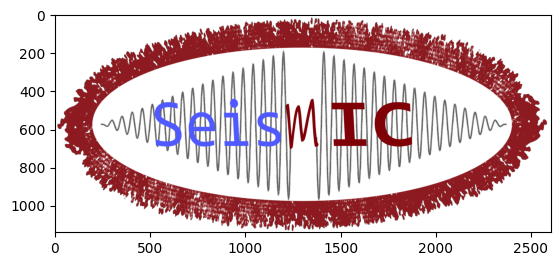

In [85]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
 
# Read Images
img = mpimg.imread('../docs/source/figures/seismic_logo_hq.png')
 
# Output Images
plt.imshow(img)

In [86]:

from copy import deepcopy
img2 = deepcopy(img[200:-250:10, 500:-700:10, 0])
img2[np.where(img2==img2[20, 5])] = 0
img2[np.where(img2==img2[20, 15])] = 0
img2[np.where(img2==img2[0, 0])] = 1.5
# img2[np.where(img2==img2[600, 600])] = -1.5
img2[np.all([img2<.4, img2>0], axis=0)] = -1.5

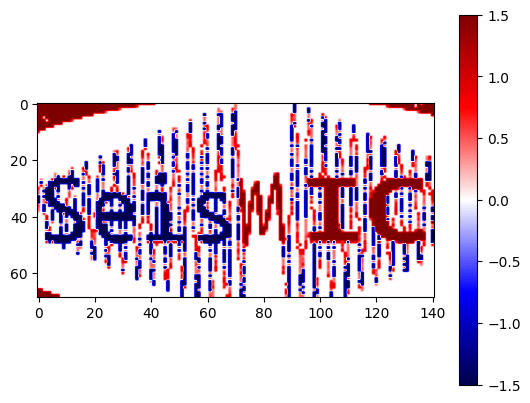

In [87]:
plt.imshow(np.array(img2), cmap='seismic')
plt.colorbar()

In [113]:
# importing matplotlib modules
import numpy as np
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from seismic.monitor.spatial import DVGrid


# define map dimensions
# New, slightly larger coverage
lat = 0
lon = 0

# X and Y-extent in km
y, x = img2.shape
y = (y-1)/4
x = (x-1)/4

# Resolution
res = .25  # km

dvg = DVGrid(lat, lon, res, x, y)

In [114]:
# make a randomized station distribution along the img2 model
# set seed so it does generate same numbers
np.random.seed(1234)
# number of stations
nsta = 15
# randomize station distribution
sta_x = np.random.random(nsta)*x
sta_y = np.random.random(nsta)*y

# convert into lat/lon
sta_lon = sta_x/111.19492664455873  # not 100% but good enough as close to equator
sta_lat = sta_y/111.19492664455873

# all possible coordinate combinations
sta0 = []
sta1 = []
for slat0, slon0 in zip(sta_lat, sta_lon):
    for slat1, slon1 in zip(sta_lat, sta_lon):
        if slat0 == slat1 and slon0 == slon1:
            continue
        sta0.append((slat0, slon0))
        sta1.append((slat1, slon1))
fwd_model = dvg.forward_model(
    img2, .1, 3, 50, tw=(10, 30), stat0=sta0, stat1=sta1)

In [115]:
from seismic.monitor.dv import DV
from seismic.correlate.stats import CorrStats

# create synthetic DV objects based on the forward model
dvs = []
for v, sta, ev in zip(fwd_model, sta0, sta1):
    cst = CorrStats(
        {'stla': sta[0], 'stlo': sta[1], 'evla': ev[0], 'evlo': ev[1],
        'corr_start': np.array([UTCDateTime(0)]), 'corr_end': np.array([UTCDateTime(1)])})
    dv = DV(
        np.array([1]), np.array([-v/100]), 'stretch', None,
        None, 'modelled', cst,
        dv_processing={
            'tw_start': 10, 'tw_len': 20,
            'freq_min': 1, 'freq_max': 3})
    dvs.append(dv)

In [116]:
inverse_model = dvg.compute_dv_grid(dvs, UTCDateTime(0), .5, 3, 50, 1, 1, .32)

<Axes: xlabel='Easting [km]', ylabel='Northing [km]'>

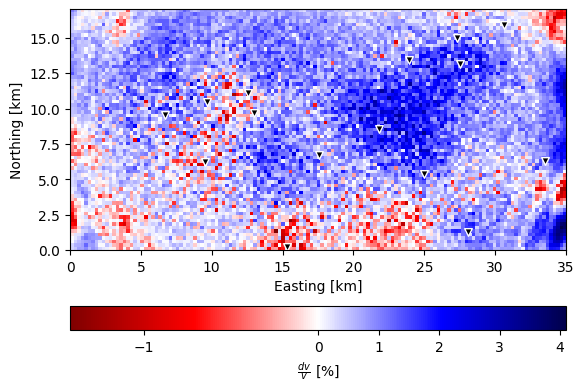

In [117]:
dvg.plot()

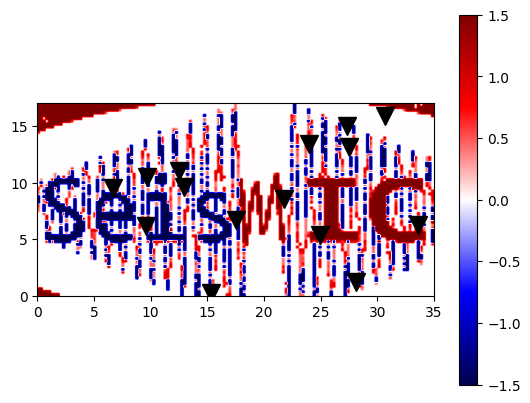

In [97]:
plt.imshow(np.array(img2), cmap='seismic', extent=[0, x, 0, y])
plt.colorbar()
plt.plot(sta_x, sta_y, 'v', color='k', ms=13)

# References
List of references used in this notebook.

[Illien, Luc, Christoph Sens-Schönfelder, and Kuan-Yu Ke. "Resolving minute temporal seismic velocity changes induced by earthquake damage: the more stations, the merrier?." Geophysical Journal International 234.1 (2023): 124-135.](https://doi.org/10.1093/gji/ggad038)

[Makus, P., Sens-Schönfelder, C., Illien, L., Walter, T. R., Yates, A., & Tilmann, F. (2023). Deciphering the whisper of volcanoes: Monitoring velocity changes at Kamchatka's Klyuchevskoy group with fluctuating noise fields. Journal of Geophysical Research: Solid Earth, 128, e2022JB025738.](https://doi.org/10.1029/2022JB025738)

[Obermann, A., Planès, T., Larose, E., and Campillo, M. (2013), Imaging preeruptive and coeruptive structural and mechanical changes of a volcano with ambient seismic noise, J. Geophys. Res. Solid Earth, 118, 6285– 6294.](https://doi.org/10.1002/2013JB010399)

[Steinmann, R., Hadziioannou, C., & Larose, E. (2020). Effect of centimetric freezing of the near subsurface on Rayleigh and Love wave velocity in ambient seismic noise correlations. Geophysical Journal International, 224(1), 626-636.](https://doi.org/10.1093/gji/ggaa406)

